In [124]:
%pylab inline
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Loading the data

In [125]:
card_df = pd.read_csv("creditcard.csv")
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Features V1 to V28 are unidentifiable and are hidden to protect the user's identity and security purposes.

Class 1 - Fraudulent transactions, Class 0 - Otherwise

### Data Exploration

In [126]:
len(card_df.index)

284807

Percentage of fradulent transactions in data.: 0.1727485630620034


<AxesSubplot:xlabel='Class', ylabel='count'>

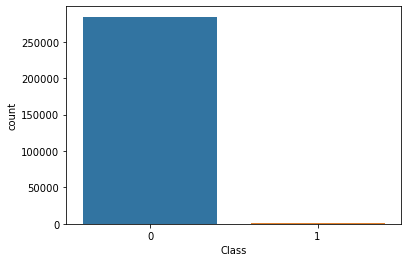

In [127]:
print('Percentage of fradulent transactions in data.:',card_df.Class.mean()*100)
sns.countplot(card_df.Class)

We find that the data is higly imbalanced, fradulent transactions are only 0.17% as compared to non-fradulent transactions. 
Any classifier on this data will give high accuracy!

#### Feature Exploration

<AxesSubplot:xlabel='Time', ylabel='Density'>

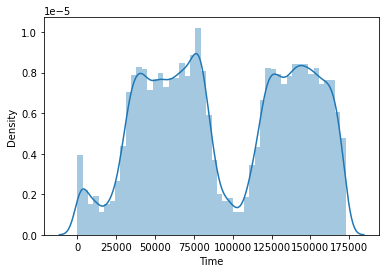

In [128]:
sns.distplot(card_df.Time)

Since Time is not affecting the transactions , we drop the variable

In [129]:
card_df.drop('Time',axis=1,inplace=True)

<AxesSubplot:xlabel='Amount'>

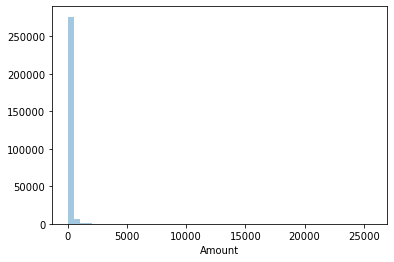

In [130]:
sns.distplot(card_df.Amount,kde=False)

Very few transactions of higher value, lower value dominates the data, so we will have to normalise the data

In [131]:
card_df['amt_normalize'] = ((card_df.Amount) - (card_df.Amount.mean()))/(card_df.Amount.std())

In [132]:
card_df1 = card_df.copy()
y = card_df.Class
X = card_df.drop(columns =['Class','Amount'])

#### Train and test data

In [133]:
X_org = X #saving original data for future
y_org = y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=123)

#### Model fitting

In [134]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)

In [135]:
print("accuracy on the training set:",logreg.score(X_train, y_train))

# check the accuracy on the test dataset
print("accuracy on the testing set:",logreg.score(X_test, y_test))

accuracy on the training set: 0.99927156482549
accuracy on the testing set: 0.9990211412216583


In [136]:
predicted = logreg.predict(X_train)
# Confusion Matrix for train data
print('Confusion Matrix on train data')
print(confusion_matrix(predicted, y_train))

# Predict class labels for the test dataset
predicted_test = logreg.predict(X_test)
# Confusion Matrix for test data
print('Confusion Matrix on test data')
print(confusion_matrix(predicted_test, y_test))

print("\nClassification report")
print(classification_report(predicted_test, y_test))

Confusion Matrix on train data
[[190482    115]
 [    24    199]]
Confusion Matrix on test data
[[93787    70]
 [   22   108]]

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93857
           1       0.61      0.83      0.70       130

    accuracy                           1.00     93987
   macro avg       0.80      0.92      0.85     93987
weighted avg       1.00      1.00      1.00     93987



Since the confusion matrix for both test and training data is similar, there is no overfitting.

Since accuracy is not the best criteria and we need to minimize the fraudulent transactions, we focus on <b>recall, precision and F1score</b>  

Here <b> recall-83%, precison - 61%, F1 score - 70%</b>

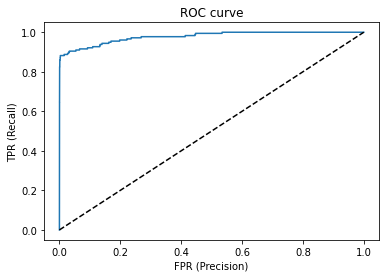

Area under curve (AUC):  0.9776754727900978


In [137]:
#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

*Though AUC is high, but model is not predicting the fraudulent transactions well! AUC is high bcs of imbalanced data*

### Techniques to cater for imbalanced data

#### Cross validation

In [138]:
# on training data
scores = cross_val_score(logreg, X_train, y_train,cv=10)
y_pred = cross_val_predict(logreg, X_train, y_train, cv=10)

print("Confusion matrix")
print(confusion_matrix(y_train,y_pred))

print("Accuracy on tarining set",scores.mean())

Confusion matrix
[[190477     29]
 [   115    199]]
Accuracy on tarining set 0.9992453621213709


In [139]:
# on test data
scores_t = cross_val_score(logreg, X_test, y_test,cv=10)
y_pred_t = cross_val_predict(logreg, X_test, y_test, cv=10)

print("Confusion matrix")
print(confusion_matrix(y_test,y_pred_t))

print("Accuracy on tarining set",scores_t.mean())

Confusion matrix
[[93794    15]
 [   67   111]]
Accuracy on tarining set 0.9991275429884243


In [140]:
print("Classification report")
print(classification_report(y_pred_t,y_test))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93861
           1       0.62      0.88      0.73       126

    accuracy                           1.00     93987
   macro avg       0.81      0.94      0.86     93987
weighted avg       1.00      1.00      1.00     93987



<b> recall - 88%, precision-62%, f1score - 73%</b>

#### Oversampling using SMOTE

In [141]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X= X_org
y= y_org
X_res, y_res = sm.fit_resample(X, y)

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=0)

In [142]:
logreg = LogisticRegression()

In [143]:
logreg.fit(X_train,y_train)

LogisticRegression()

accuracy on the testing set: 0.946436945770805
[[91345  7703]
 [ 2348 86252]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95     99048
           1       0.92      0.97      0.94     88600

    accuracy                           0.95    187648
   macro avg       0.95      0.95      0.95    187648
weighted avg       0.95      0.95      0.95    187648



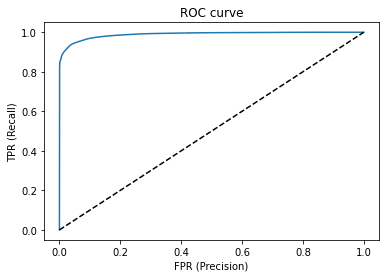

Area under curve (AUC):  0.9890619219650892


In [144]:
print("accuracy on the testing set:",logreg.score(X_test, y_test))

# Predict class labels for the test set
predicted = logreg.predict(X_test)

# Confusion Matrix for train data
print(confusion_matrix(predicted, y_test))

print(classification_report(predicted, y_test))

#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> recall-97%, precision-92%, f1score-94% </b>

#### Ensemble Modeling(Random Forest)

In [145]:
X= X_org
y= y_org

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [146]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
model_rf = rf.fit(X_train, y_train)

AUC = 0.930411226574296
Accuracy = 0.9995105706108292
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.93      0.77      0.84       162

    accuracy                           1.00     93987
   macro avg       0.97      0.89      0.92     93987
weighted avg       1.00      1.00      1.00     93987



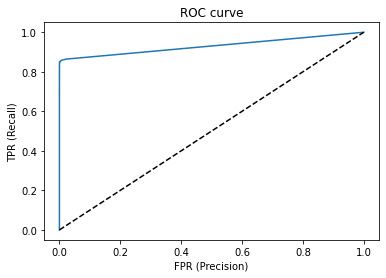

Area under curve (AUC):  0.930411226574296


In [147]:
predicted_rf = model_rf.predict(X_test)
probs_rf = model_rf.predict_proba(X_test)
print('AUC =', roc_auc_score(y_test, probs_rf[:, 1]))
print('Accuracy =', accuracy_score(y_test, predicted_rf))
print(classification_report(y_test, predicted_rf))

#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = model_rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> recall-77%, Precison-94%, F1score-84% </b>

#### Bagging

In [148]:
X= X_org
y= y_org

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93874
           1       0.62      0.88      0.73       113

    accuracy                           1.00     93987
   macro avg       0.81      0.94      0.86     93987
weighted avg       1.00      1.00      1.00     93987

Accuracy = 0.9992020173002649


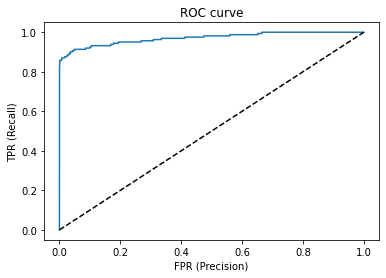

Area under curve (AUC):  0.970532347784324


In [149]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
num_trees = 100
model = BaggingClassifier(LogisticRegression())
model.fit(X_train, y_train)

#test set
predicted = model.predict(X_test)
print(classification_report(predicted, y_test))
print('Accuracy =', accuracy_score(y_test, predicted))

from sklearn.metrics import roc_curve, auc
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> Recall- 87%, Precison-62%, F1score - 73%</b> 

#### Boosting(XG Boost)

In [150]:
X= X_org
y= y_org

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

accuracy on the testing set: 0.9995637694574782
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93850
           1       0.80      0.94      0.86       137

    accuracy                           1.00     93987
   macro avg       0.90      0.97      0.93     93987
weighted avg       1.00      1.00      1.00     93987



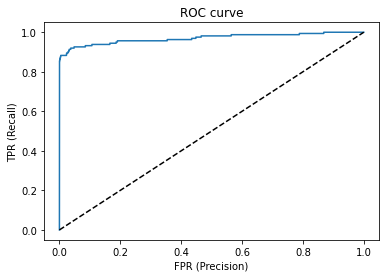

Area under curve (AUC):  0.9697731855667729


In [151]:
from xgboost import XGBClassifier
model2 = XGBClassifier(objective='reg:logistic')
model2.fit(X_train, y_train)

y_pred1 = model2.predict(X_test)
# check the accuracy on the test dataset
print("accuracy on the testing set:",model2.score(X_test, y_test))
print(classification_report(y_pred1, y_test))

#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = model2.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> recall-94%, precision-80%, f1score-86%</b>

#### Boosting(ADABoost)

In [152]:
X= X_org
y= y_org

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [153]:
from sklearn.ensemble import AdaBoostClassifier
boost = AdaBoostClassifier()

[[93804    21]
 [   56   106]]
accuracy on the testing set: 0.9991807377616053
Accuracy = 0.9991807377616053
              precision    recall  f1-score   support

           0  0.99940337 0.99977618 0.99958974     93825
           1  0.83464567 0.65432099 0.73356401       162

    accuracy                      0.99918074     93987
   macro avg  0.91702452 0.82704858 0.86657688     93987
weighted avg  0.99911938 0.99918074 0.99913120     93987

[0.44843479 0.44348364 0.44381987 ... 0.45341238 0.26069472 0.45121132]


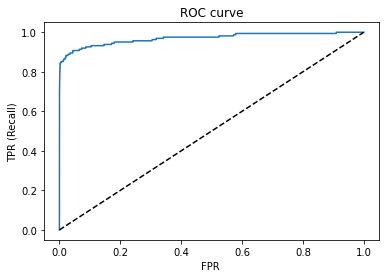

Area under curve (AUC):  0.9698149957400335


In [154]:
boost.fit(X_train, y_train)
y_pred_boost = boost.predict(X_test)
print(confusion_matrix( y_test,y_pred_boost))
print("accuracy on the testing set:",boost.score(X_test, y_test))
print('Accuracy =', accuracy_score(y_test, y_pred_boost))
print(classification_report(y_test,y_pred_boost,digits=8))

from sklearn.metrics import roc_curve, auc
y_score = boost.predict_proba(X_test)[:,1]
print(y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR ')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> recall-65%, precision-83%, F1score-73% </b>

#### Results:

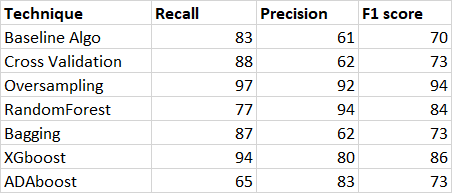

Out of all the methods, oversampling(SMOTE) has the highest recall, precision and F1score.